### Import Library dan Mount Google Drive

In [ ]:
# Import library dasar
import os  # operasi file dan direktori
import random  # untuk memilih gambar acak
import numpy as np  # manipulasi array
import matplotlib.pyplot as plt  # visualisasi
import tensorflow as tf  # framework deep learning
import cv2  # untuk membaca dan memproses gambar
from PIL import Image  # untuk menyimpan gambar
from glob import glob  # mencari file berdasarkan pola
from tensorflow.keras.preprocessing.image import array_to_img  # konversi array ke objek image
from collections import Counter  # menghitung frekuensi elemen

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')  # menghubungkan Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Menampilkan Gambar Mentah dari Setiap Kelas

Visualisasi contoh gambar mentah dari setiap kelas di dataset.

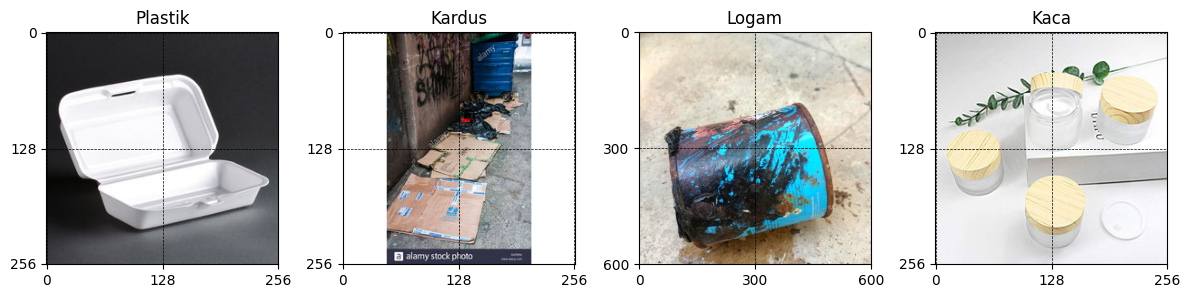

In [ ]:
# Path ke direktori dataset mentah
raw_dir = '/content/drive/MyDrive/TA/Dataset'

# Visualisasi 1 gambar acak dari setiap kelas
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(os.listdir(raw_dir)):
    # Pilih satu file gambar acak dari kelas tertentu
    img_path = random.choice(glob(os.path.join(raw_dir, class_name, '*.jpg')))
    img = cv2.imread(img_path)  # baca gambar
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # konversi BGR ke RGB

    # Tampilkan gambar dalam subplot
    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.xticks([0, img.shape[1]//2, img.shape[1]-1], labels=[0, img.shape[1]//2, img.shape[1]], color='black')
    plt.yticks([0, img.shape[0]//2, img.shape[0]-1], labels=[0, img.shape[0]//2, img.shape[0]], color='black')
    plt.grid(visible=True, color='black', linestyle='--', linewidth=0.5)
    plt.gca().spines['top'].set_color('black')
    plt.gca().spines['bottom'].set_color('black')
    plt.gca().spines['left'].set_color('black')
    plt.gca().spines['right'].set_color('black')

plt.tight_layout()
plt.show()

### Membaca Dataset Mentah dan Menghitung Jumlah Gambar per Kelas

In [ ]:
raw_data = tf.keras.utils.image_dataset_from_directory(
    raw_dir,  # path ke folder dataset mentah
    image_size=(224, 224),  # resize ke ukuran 224x224
    batch_size=1,  # batch size kecil agar bisa dihitung satu per satu
    shuffle=False  # jangan acak karena perlu tahu urutan
)

class_names = raw_data.class_names  # ambil nama kelas
print("Class names:", class_names)

# Hitung jumlah gambar per kelas
label_counts = Counter()
for _, labels in raw_data:
    label = labels.numpy()[0]  # ambil label dalam format integer
    class_name = class_names[label]
    label_counts[class_name] += 1

# Tampilkan hasil per kelas
print("\nJumlah gambar per kelas:")
total = 0
for class_name in class_names:
    count = label_counts[class_name]
    print(f"{class_name}: {count}")
    total += count

print(f"\nTotal semua gambar: {total}")

Found 4400 files belonging to 4 classes.
Class names: ['Kaca', 'Kardus', 'Logam', 'Plastik']

Jumlah gambar per kelas:
Kaca: 1100
Kardus: 1100
Logam: 1100
Plastik: 1100

Total semua gambar: 4400


### Visualisasi Gambar Acak dari Tiap Kelas
Tampilkan satu contoh gambar dari setiap kelas untuk inspeksi kualitas visual.

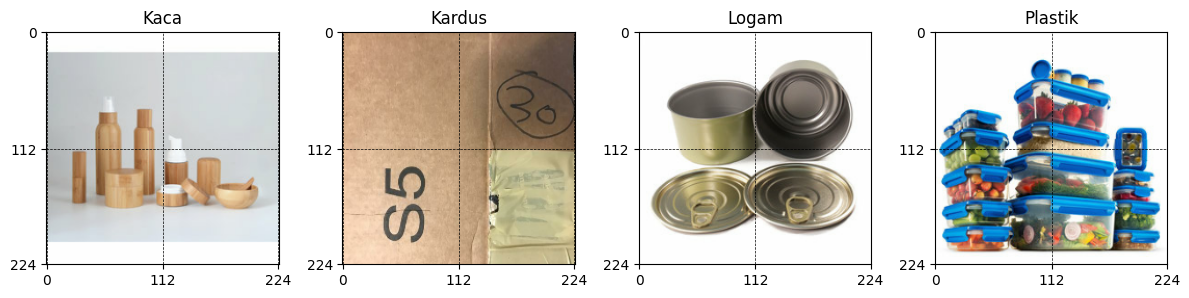

In [ ]:
# Kumpulkan semua gambar ke dalam dict berdasarkan kelas
class_images = {cls: [] for cls in class_names}
for image, label in raw_data:
    class_index = int(label.numpy()[0])
    class_name = class_names[class_index]
    class_images[class_name].append(image[0].numpy().astype("uint8"))

# Ambil 1 gambar acak untuk tiap kelas
sample_images = {cls: random.choice(imgs) for cls, imgs in class_images.items()}

# Tampilkan
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(class_names):
    img = sample_images[class_name]
    plt.subplot(1, len(class_names), i + 1)
    plt.imshow(img)
    plt.title(class_name)

    h, w, _ = img.shape
    plt.xticks([0, w//2, w-1], labels=[0, w//2, w], color='black')
    plt.yticks([0, h//2, h-1], labels=[0, h//2, h], color='black')
    plt.grid(visible=True, color='black', linestyle='--', linewidth=0.5)

    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_edgecolor('black')

plt.tight_layout()
plt.show()


### Augmentasi Gambar dan Simpan ke Folder Baru
Lakukan augmentasi manual: flip, rotasi, dan zoom, lalu simpan ke direktori baru.

In [ ]:
aug_dir = '/content/drive/MyDrive/TA/Dataset Final'  # direktori untuk menyimpan hasil augmentasi akhir
os.makedirs(aug_dir, exist_ok=True)  # buat folder jika belum ada

# Inisialisasi counter untuk setiap kelas
class_counters = {cls: 1 for cls in class_names}

# Loop untuk setiap gambar dan augmentasinya
for batch in raw_data:
    images, labels = batch
    image = tf.squeeze(images[0]).numpy().astype("uint8")  # ubah tensor ke numpy
    label = labels[0].numpy()
    class_name = class_names[label]
    count = class_counters[class_name]

    save_path = os.path.join(aug_dir, class_name)
    os.makedirs(save_path, exist_ok=True)

    # Simpan original
    array_to_img(image).save(os.path.join(save_path, f"{class_name}Ori({count:02d}).jpg"))
    # Flip horizontal
    flipped = tf.image.flip_left_right(image)
    array_to_img(flipped).save(os.path.join(save_path, f"{class_name}Flip({count:02d}).jpg"))
    # Rotasi 90 derajat
    rotated = tf.image.rot90(image)
    array_to_img(rotated).save(os.path.join(save_path, f"{class_name}Rotation({count:02d}).jpg"))
    # Zoom (crop tengah dan resize)
    crop = tf.image.central_crop(image, 0.8)
    zoomed = tf.image.resize(crop, (224, 224))
    array_to_img(tf.cast(zoomed, tf.uint8)).save(os.path.join(save_path, f"{class_name}Zoom({count:02d}).jpg"))

    class_counters[class_name] += 1


### Cek Jumlah Gambar Setelah Augmentasi

Memastikan jumlah gambar bertambah dan seimbang di setiap kelas.

In [ ]:
class_names = sorted(os.listdir(aug_dir))
print("Class names:", class_names)

print("\nJumlah gambar per kelas (setelah augmentasi):")
total = 0
for class_name in class_names:
    class_path = os.path.join(aug_dir, class_name)
    if os.path.isdir(class_path):
        image_count = len(glob(os.path.join(class_path, '*.jpg')))
        print(f"{class_name}: {image_count} gambar")
        total += image_count

print(f"\nTotal semua gambar: {total}")

Class names: ['Kaca', 'Kardus', 'Logam', 'Plastik']

Jumlah gambar per kelas (setelah augmentasi):
Kaca: 4400 gambar
Kardus: 4400 gambar
Logam: 4400 gambar
Plastik: 4400 gambar

Total semua gambar: 17600


### Visualisasi Hasil Augmentasi per Kelas
Tampilkan hasil dari setiap jenis augmentasi (Ori, Flip, Rotation, Zoom).

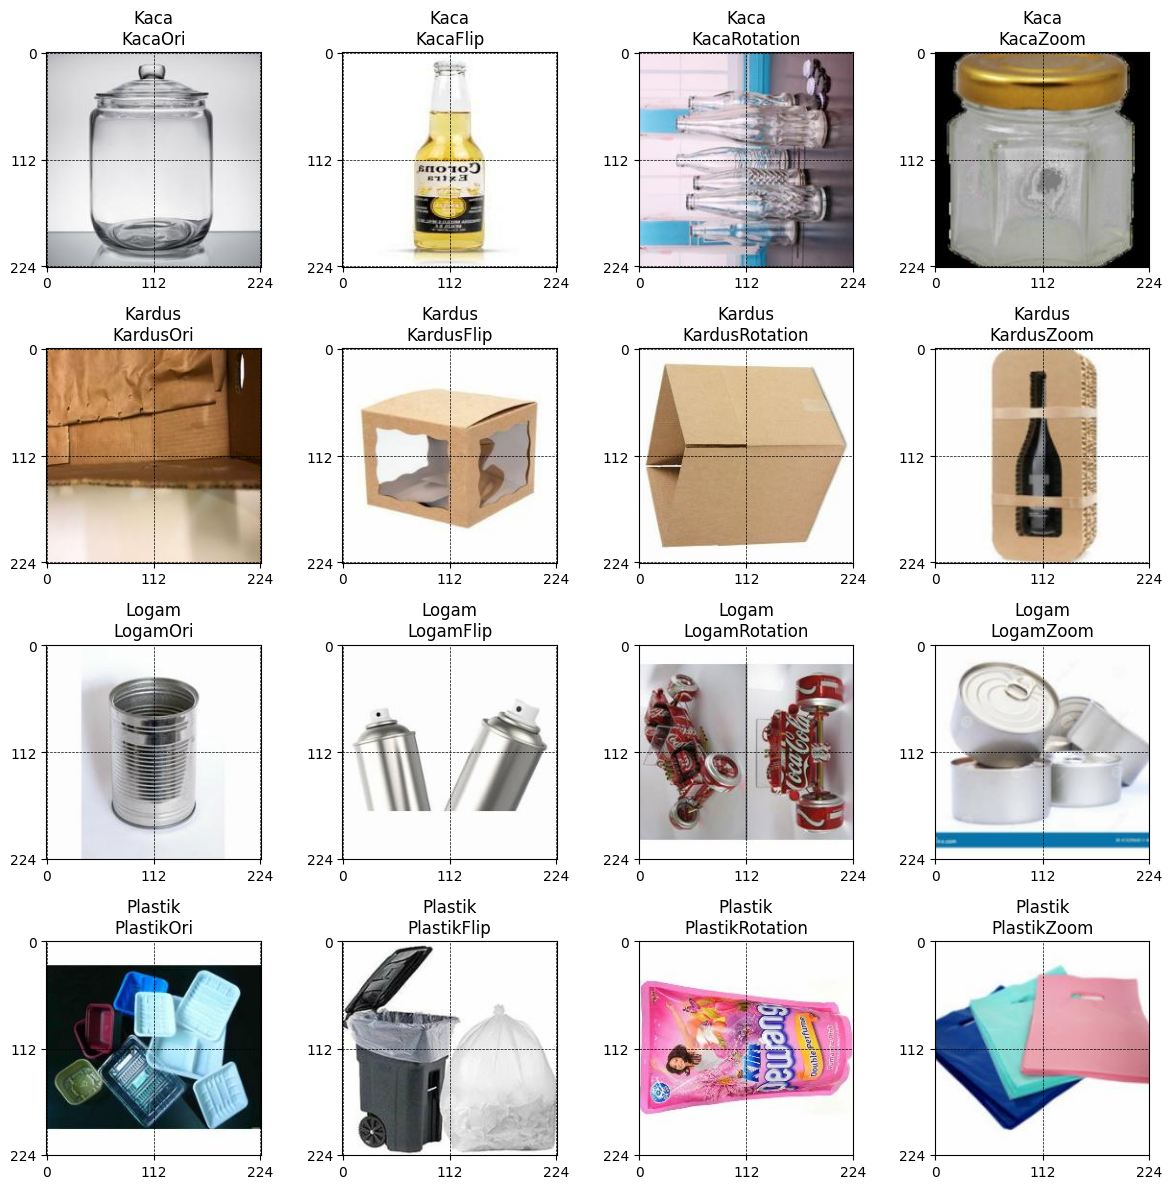

In [ ]:
plt.figure(figsize=(12, 12))
plot_index = 1

for class_name in class_names:
    class_path = os.path.join(aug_dir, class_name)
    ori = sorted(glob(os.path.join(class_path, f"{class_name}Ori*.jpg")))
    flip = sorted(glob(os.path.join(class_path, f"{class_name}Flip*.jpg")))
    rot = sorted(glob(os.path.join(class_path, f"{class_name}Rotation*.jpg")))
    zoom = sorted(glob(os.path.join(class_path, f"{class_name}Zoom*.jpg")))

    img_paths = [random.choice(ori), random.choice(flip), random.choice(rot), random.choice(zoom)]

    for img_path in img_paths:
        img = Image.open(img_path)
        plt.subplot(len(class_names), 4, plot_index)
        plt.imshow(img)

        # Tambah grid dan ukuran
        h, w = img.size
        plt.xticks([0, w//2, w-1], labels=[0, w//2, w], color='black')
        plt.yticks([0, h//2, h-1], labels=[0, h//2, h], color='black')
        plt.grid(visible=True, color='black', linestyle='--', linewidth=0.5)

        # Judul dan bingkai
        plt.title(f"{class_name}\n{os.path.basename(img_path).split('(')[0]}")
        ax = plt.gca()
        for spine in ax.spines.values():
            spine.set_edgecolor('black')

        plot_index += 1

plt.tight_layout()
plt.show()
